In [2]:
#import necessary packages
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz

In [3]:
import urllib.request, urllib.parse
from urllib.error import HTTPError,URLError

def get_countries_data():
    """
    Function to get information like population from all countries
    """
    url = 'https://restcountries.eu/rest/v2/all'
    try:
        uh = urllib.request.urlopen(url)
    except HTTPError as e:
        print("Sorry! Could not retrive anything on {}".format(country_name))
        return None
    except URLError as e:
        print('Failed to reach a server.')
        print('Reason: ', e.reason)
        return None
    else:
        data = uh.read().decode()
        return data

In [4]:
countries_data = get_countries_data()

In [5]:
#make a request to worldometers coronavirus page
worldo = requests.get('https://www.worldometers.info/coronavirus/')

In [6]:
#Parse the page using beautifulsoup and extract the table containing covid-19 cases
soup = BeautifulSoup(worldo.text, 'lxml')
table = soup.find_all('table')
#Create a pandas dataframe object out of the parsed page
worldometer_dataframe = pd.read_html(str(table))[0]
columns = ['Country', 'Total Cases', 'Drop1', 'Total Deaths', 
           'Drop2', 'Total Recovered', 'Active Cases', 'Serious / Critical Cases', 'Drop3', 'Drop4', 'Total Tests', 'Drop5']
worldometer_dataframe.columns = columns
worldometer_dataframe.drop(['Drop1', 'Drop2', 'Drop3', 'Drop4', 'Drop5'], axis=1, inplace=True)
worldometer_dataframe.drop([0, len(worldometer_dataframe.index) -1 ], inplace=True)#Remove the first and last rows from thetable

In [7]:
population_json = json.loads(countries_data)
worldometer_json = json.loads(worldometer_dataframe.to_json(orient="records"))
# countries_all_data

In [14]:
countries =[{'name': country['name'] ,'alt': country['altSpellings'] , 'native name': country['nativeName'], 'population': country['population']} for country in population_json]

for each_dict in worldometer_json:#First iteration that compares the country name in the worldometer table to the country name gotten from restcountries.eu api
    for country in countries:
        if (each_dict['Country'] == country['name']) or (each_dict['Country'] == country['native name']):
            each_dict['population'] = country['population']
            countries.remove(country)#remove the country from the list to make it smaller

for each_dict in worldometer_json:
    if 'population' not in each_dict:
        for country in countries:
            if(fuzz.partial_ratio(each_dict['Country'], country['name']) == 100):
                each_dict['population'] = country['population']
                countries.remove(country)
                
for each_dict in worldometer_json:
    if 'population' not in each_dict:
        for country in countries:
            if each_dict['Country'] in country['alt']:
                each_dict['population'] = country['population']
                countries.remove(country)
                         
mapping = {'S. Korea' : 'Korea (Republic of)', 
           'Czechia': 'Czech Republic', 
           'Vietnam' : 'Viet Nam', 
           'North Macedonia': 'Macedonia (the former Yugoslav Republic of)'}

for each_dict in worldometer_json:
    if ('population' not in each_dict) and (each_dict['Country'] in mapping):
        for country in countries: 
            if (country['name'] == mapping[each_dict['Country']]):
                each_dict['population'] = country['population']
                countries.remove(country)

In [15]:
corona_virus_detailed_table = pd.DataFrame(worldometer_json)
corona_virus_detailed_table.sort_values(by='Total Cases', ascending=False, inplace=True)
corona_virus_detailed_table.index = range(1, len(worldometer_dataframe) + 1)
corona_virus_detailed_table.head(20)

,Country,Total Cases,Total Deaths,Total Recovered,Active Cases,Serious / Critical Cases,Total Tests,population
1,USA,1115977,65029.0,158287.0,892661,15151.0,6582551.0,3.239470e+08
2,Spain,242988,24824.0,142450.0,75714,2500.0,1528833.0,4.643842e+07
3,Italy,207428,28236.0,78249.0,100943,1578.0,2053425.0,6.066555e+07
4,UK,177454,27510.0,NaN,149600,1559.0,1023824.0,6.511000e+07
5,France,167346,24594.0,50212.0,92540,3878.0,724574.0,6.671000e+07
6,Germany,163759,6662.0,126900.0,30197,2189.0,2547052.0,8.177090e+07
7,Turkey,122392,3258.0,53808.0,65326,1480.0,1075048.0,7.874105e+07
8,Russia,114431,1169.0,13220.0,100042,2300.0,3700000.0,1.465992e+08
9,Iran,95646,6091.0,76318.0,13237,2899.0,475023.0,7.936990e+07
10,Brazil,87364,6017.0,35935.0,45412,8318.0,339552.0,2.061359e+08


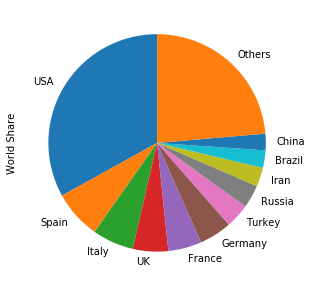

In [16]:
columns = ['Country', 'Total Cases']
countries_world_share = pd.DataFrame(corona_virus_detailed_table, columns = columns)
countries_world_share['World Share'] = countries_world_share['Total Cases'] / sum(countries_world_share['Total Cases']) * 100
more_than_2 = countries_world_share[countries_world_share['World Share'] >= 2]
less_than_2 = countries_world_share[countries_world_share['World Share'] < 2]
others = pd.DataFrame({'Country' : 'Others', 'Total Cases' : less_than_2['Total Cases'].sum(), 
                       'World Share': less_than_2['World Share'].sum()}, index=[len(more_than_2) + 1])

world_share_aggregate = pd.concat([more_than_2, others], axis=0)
world_share_aggregate.set_index('Country').plot.pie(y='World Share', figsize=(5,5), startangle=90, legend=False)
plt.show()

In [18]:
world_share_aggregate[:20]

,Country,Total Cases,World Share
1,USA,1115977,33.056974
2,Spain,242988,7.197682
3,Italy,207428,6.144340
4,UK,177454,5.256463
5,France,167346,4.957049
6,Germany,163759,4.850796
7,Turkey,122392,3.625441
8,Russia,114431,3.389624
9,Iran,95646,2.833183
10,Brazil,87364,2.587858


In [20]:
corona_virus_detailed_table[corona_virus_detailed_table['population'].isna() ]

,Country,Total Cases,Total Deaths,Total Recovered,Active Cases,Serious / Critical Cases,Total Tests,population
99,Diamond Princess,712,13.0,645.0,54,4.0,NaN,NaN
109,Channel Islands,538,41.0,406.0,91,NaN,5342.0,NaN
133,Faeroe Islands,187,NaN,184.0,3,NaN,7081.0,NaN
150,Eswatini,106,1.0,12.0,93,NaN,714.0,NaN
164,CAR,64,NaN,10.0,54,NaN,NaN,NaN
187,St. Vincent Grenadines,16,NaN,8.0,8,NaN,108.0,NaN
200,Vatican City,11,NaN,2.0,9,NaN,NaN,NaN
203,MS Zaandam,9,2.0,NaN,7,NaN,NaN,NaN
209,St. Barth,6,NaN,6.0,0,NaN,NaN,NaN
211,Caribbean Netherlands,5,NaN,NaN,5,NaN,110.0,NaN


In [23]:
corona_virus_detailed_table[corona_virus_detailed_table['Country'].isin([ 'S. Korea', 'Czechia', 'Vietnam', 'North Macedonia'])  ]

,Country,Total Cases,Total Deaths,Total Recovered,Active Cases,Serious / Critical Cases,Total Tests,population
36,S. Korea,10774,248.0,9072.0,1454,55.0,623069.0,50801405.0
43,Czechia,7726,240.0,3359.0,4127,67.0,249634.0,10558524.0
79,North Macedonia,1494,81.0,807.0,606,13.0,16798.0,2058539.0
128,Vietnam,270,NaN,219.0,51,8.0,261004.0,92700000.0
